In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Descrição

Esse notebook tem como objetivo demonstrar a utilização de algoritmos que estimam a dimensão intrínseca de um conjunto de dados.

## Funções auxiliares

In [2]:
def derivate(data, v):
    """
    Função que calcula derivada (centrada).
    
    Params
    ------
    data : numpy.array
        Array contendo os valores 'y' da derivada.
    v : numpy.array
        Array contendo os valores 'x' da derivada.
        
    Returns
    -------
    data_d : numpy.array
        Derivada do array 'data'.
    v_d : numpy.array
        Array 'x' atualizado.
    """
    v_d = v[1:-1]
    data_d = np.zeros(data.size-2)
    for i in range(1,data.size-1):
        data_d[i-1] = (data[i+1] - data[i-1])/(2*(v_d[1] - v_d[0]))
    return data_d, v_d


def randomCubid(N, d, D, A=0):
    """
    Cria um hipercúbido, de dimensão 'd'. Em seguida, é transformado em uma dimensão
    maior, 'D'. Embora a dimensão dos dados fique 'D' no final da função, a sua 
    dimensão intrínseca continua sendo 'd'.
    
    Params
    ------
    N : int
        Número de pontos gerados.
    d : int
        Dimensão original dos dados (dimensão intrínseca).
    D : int
        Dimensão final dos dados.
    A : float (default = 0.0)
        Nível de ruído.
        
    Returns
    -------
    output : numpy.array
        Array com dados de dimensão 'D' e dimensão intrínseca 'd'.
    """
    data_d = np.random.random((N, d))
    centers = np.random.random((D,d))
    data_D = np.apply_along_axis(lambda row: np.linalg.norm(row - data_d, axis=1), 1, centers).T
    output = data_D + A*2*(np.random.random(data_D.shape) - 0.5)
    return output

## Grasberger-Procaccia (Correlation Dimension)

In [3]:
def CorrelationDimension(data, num_points=100):
    """
    Algoritmo GP. Note que, para um resultado preciso, seria necessário um número
    de pontos igual a 10^(D/2), onde D é a dimensão do conjunto de pontos. Cria dois
    arrays, C2 e v. A dimensão intrínseca é o coeficiente angular da região em que 
    a curva C2 vs v se torna próxima de uma reta.
    
    Params
    ------
    data : numpy.array
        Array com os dados de entrada. Formato NxD (N = número de pontos / D = Dimensão)
    num_points : int (default = 100)
        Número de pontos utilizados para estimar C2.
    
    Returns
    -------
    C2_values : numpy.array
        Valores de C2 para plotar.
    v : numpy.array
        Valores de v para plotar.
    """
    from scipy.spatial.distance import pdist
    dist_array = pdist(data)
    max_d = np.log(np.max(dist_array))
    min_d = np.log(np.min(dist_array))
    v_all = np.linspace(min_d, max_d, num_points)
    v_all = np.exp(v_all)
    n = data.shape[0]
    C2_values = np.zeros(v_all.size-1)
    for i in range(1,v_all.size):
        value = np.sum(dist_array<=v_all[i])/n 
        C2_values[i-1] = np.log(value)
    v = np.log(v_all[1:])
    return C2_values, v

## Camastra-Vinciarelli

In [4]:
def generateGamma(d_max, D, N):
    """
    Algoritmo Camastra-Vinciarelli. Ele é baseado no algoritmo GP, ajuda a 
    acelerar o processo de 'convergência' do GP.
    """
    from sklearn.linear_model import LinearRegression
    d_array = np.zeros(d_max)
    D_array = np.zeros(d_max)
    for d in range(d_max):
        data_d = np.random.random((N, d+1))
        centers = np.random.random((D,d+1))
        data_D = np.apply_along_axis(lambda row: np.linalg.norm(row - data_d, axis=1), 1, centers).T
        C2, v = CorrelationDimension(data_D, num_points=100)
        Di = LinearRegression().fit(v[20:40].reshape(-1,1), C2[20:40]).coef_[0]
        d_array[d] = d+1
        D_array[d] = Di
    return d_array, D_array

## Two Nearest Neighbors

In [5]:
def TwoNN(data):
    """
    Método que utiliza 2 vizinhos mais próximos. Funcionamento parecido com o algoritmo GP.
    
    Params
    ------
    data : numpy.array
        Dados no formato NxD (N = número de pontos / D = dimensão)
        
    Returns
    -------
    x : numpy.array
        Array para plot (x).
    y : numpy.array
        Array para plot (y).
    """
    def createUrow(row):
        row_s = np.sort(row)
        return row_s[2]/row_s[1]

    def createU(data):
        dists = cdist(data, data)
        return np.apply_along_axis(createUrow, 1, dists)
    from scipy.spatial.distance import cdist
    u = createU(data)
    idx = np.argsort(u)
    N = len(data)
    F = np.arange(len(u))/N
    x = np.log(u[idx])
    y = -np.log(1 - F)
    return x,y

# Main

## Dados sem ruído

(10000, 20)


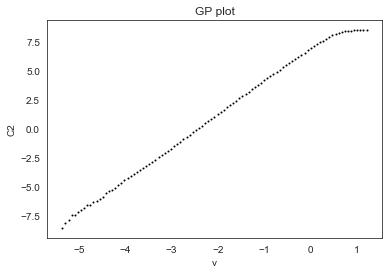

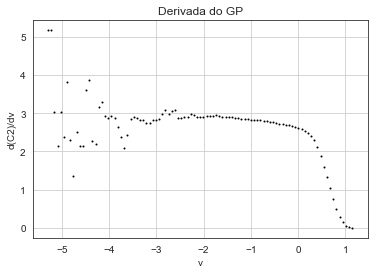

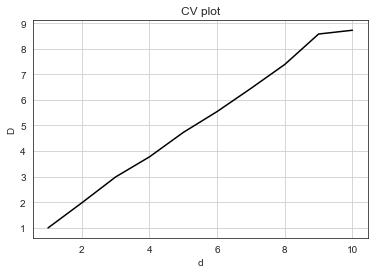

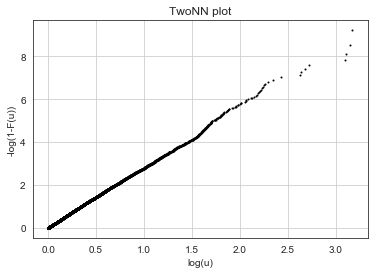

In [6]:
### Gerando dados 
data = randomCubid(10000, 3, 20)

print(data.shape)

### Estimadores
# GP
C2, v = CorrelationDimension(data)
C2_d, v_d = derivate(C2,v)

with sns.axes_style('white'):
    plt.scatter(v,C2,s=1,c='black')
    plt.xlabel('v')
    plt.ylabel('C2')
    plt.title("GP plot")
    plt.show()
    
with sns.axes_style('white'):
    plt.scatter(v_d,C2_d,s=1,c='black')
    plt.xlabel('v')
    plt.ylabel('d(C2)/dv')
    plt.title("Derivada do GP")
    plt.grid()
    plt.show()
    
    
# CV
x, y = generateGamma(10, 20, 10000)

with sns.axes_style('white'):
    plt.plot(x,y,c='black')
    plt.xlabel('d')
    plt.ylabel('D')
    plt.title("CV plot")
    plt.grid()
    plt.show()
    
    
# TwoNN 
x, y = TwoNN(data)

with sns.axes_style('white'):
    plt.scatter(x,y,s=1,c='black')
    plt.xlabel('log(u)')
    plt.ylabel('-log(1-F(u))')
    plt.title("TwoNN plot")
    plt.grid()
    plt.show()

(1000, 20)


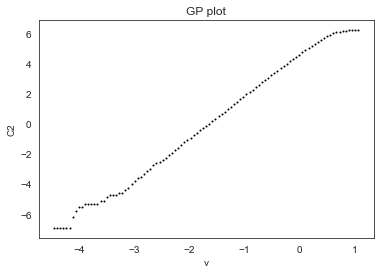

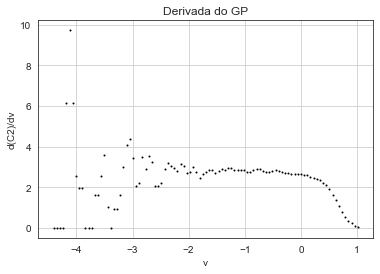

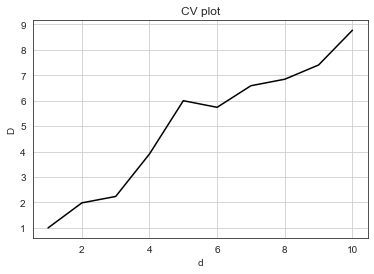

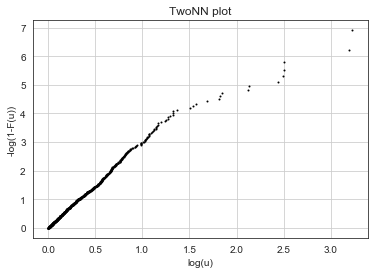

In [7]:
### Gerando dados 
data = randomCubid(1000, 3, 20)

print(data.shape)

### Estimadores
# GP
C2, v = CorrelationDimension(data)
C2_d, v_d = derivate(C2,v)

with sns.axes_style('white'):
    plt.scatter(v,C2,s=1,c='black')
    plt.xlabel('v')
    plt.ylabel('C2')
    plt.title("GP plot")
    plt.show()
    
with sns.axes_style('white'):
    plt.scatter(v_d,C2_d,s=1,c='black')
    plt.xlabel('v')
    plt.ylabel('d(C2)/dv')
    plt.title("Derivada do GP")
    plt.grid()
    plt.show()
    
    
# CV
x, y = generateGamma(10, 20, 1000)

with sns.axes_style('white'):
    plt.plot(x,y,c='black')
    plt.xlabel('d')
    plt.ylabel('D')
    plt.title("CV plot")
    plt.grid()
    plt.show()
    
    
# TwoNN 
x, y = TwoNN(data)

with sns.axes_style('white'):
    plt.scatter(x,y,s=1,c='black')
    plt.xlabel('log(u)')
    plt.ylabel('-log(1-F(u))')
    plt.title("TwoNN plot")
    plt.grid()
    plt.show()